In [1]:
import ott
import matplotlib.pyplot as plt
import numpy as np
import optax
import jax
import jax.numpy as jnp
import scanpy as sc
from entot.models.model import OTFlowMatching
from entot.nets.nets import MLP_vector_field, Bridge_MLP_constant
from entot.plotting.plots import plot_1D_balanced

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/equinox/_ad.py:753: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(
2023-08-29 17:26:50.333094: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not 

In [2]:
adata = sc.read("../../data/adata_pancreas_2019_endocrine.h5ad")

In [3]:
sc.pp.pca(adata, n_comps=30)

In [4]:
source = adata[adata.obs["day"]=="14.5"].obsm["X_pca"]
target = adata[adata.obs["day"]=="15.5"].obsm["X_pca"]


In [24]:
neural_net = MLP_vector_field(30, 128, 128, 128)
bridge_net = Bridge_MLP_constant2(30, 128, 128)

In [25]:
ot_solver=ott.solvers.linear.sinkhorn.Sinkhorn()
            #momentum=ott.solvers.linear.acceleration.Momentum(value=1., start=25)
        #)

otfm = OTFlowMatching(neural_net, bridge_net=bridge_net, ot_solver=ot_solver, epsilon=1e-2, input_dim=30, output_dim=30, iterations=10_000, k_noise_per_x=10)

In [26]:
otfm(source, target, 1024, 1024)

  6%|▌         | 603/10000 [02:03<31:58,  4.90it/s] 


KeyboardInterrupt: 

In [23]:
from ott.solvers.nn.models import ModelBase, NeuralTrainState
import flax.linen as nn
from flax.training import train_state
from typing import Callable

class Bridge_MLP_constant2(ModelBase):
    output_dim: int
    t_embed_dim: int
    condition_embed_dim: int
    is_potential: bool = False
    act_fn: Callable[[jnp.ndarray], jnp.ndarray] = nn.silu

    @nn.compact
    def __call__(self, condition: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray]:  # noqa: D102
        return jnp.zeros((*condition.shape[:-1], self.output_dim)), jnp.ones((*condition.shape[:-1], self.output_dim))

    def create_train_state(
        self,
        rng: jax.random.PRNGKeyArray,
        optimizer: optax.OptState,
        input_dim: int,
    ) -> NeuralTrainState:
        return train_state.TrainState.create(apply_fn=self.apply, params={}, tx=optimizer)

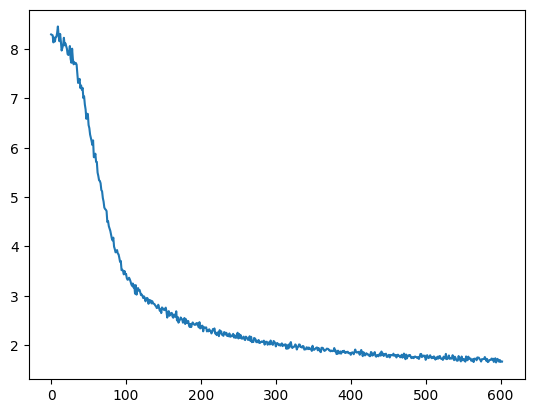

In [27]:
plt.plot(np.arange(len(otfm.metrics["loss"])), otfm.metrics["loss"])

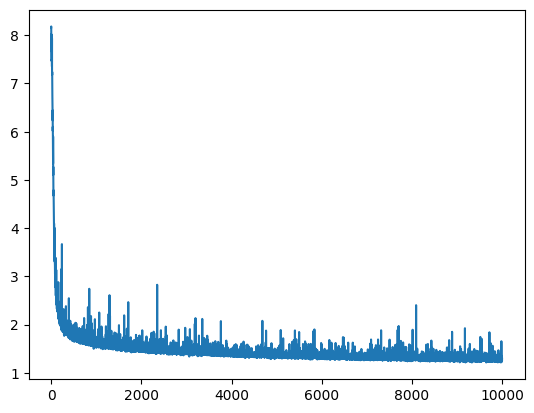

In [27]:
plt.plot(np.arange(len(otfm.metrics["loss"])), otfm.metrics["loss"])

In [36]:
pushed,_, resc = otfm.transport(source, seed=2)

In [37]:
bdata = adata.copy()
bdata.obsm["X_pca_result"] = np.concatenate((pushed[0,...], target), axis=0)

In [38]:
sc.pp.neighbors(bdata, use_rep="X_pca_result")

In [39]:
sc.tl.umap(bdata)

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


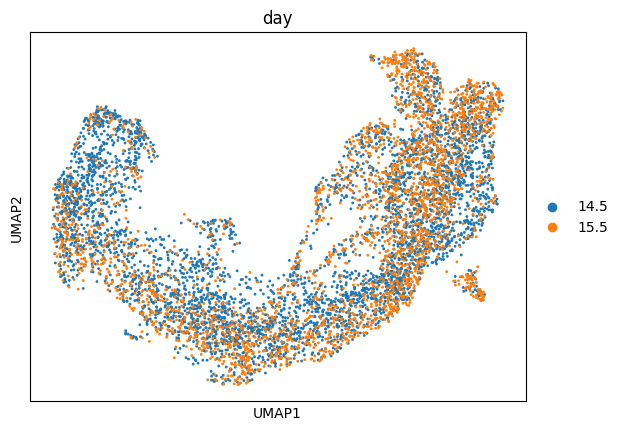

In [40]:
sc.pl.umap(bdata, color="day")

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


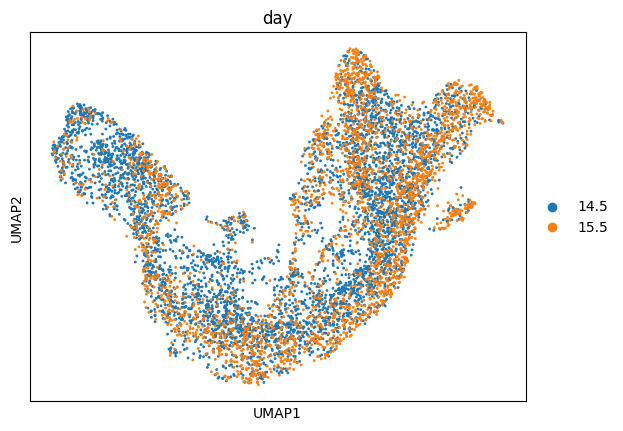

In [32]:
sc.pl.umap(bdata, color="day")

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


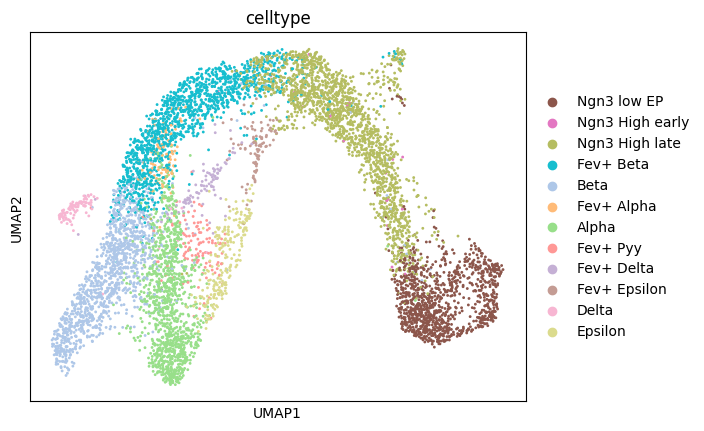

In [15]:
sc.pl.umap(bdata, color="celltype")

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


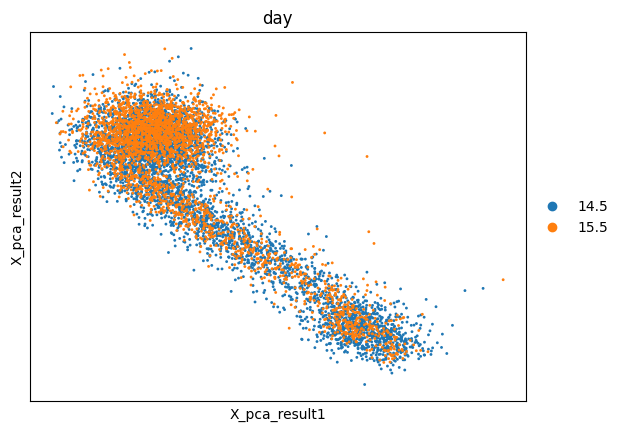

In [16]:
sc.pl.embedding(bdata, basis="X_pca_result", color="day")

/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


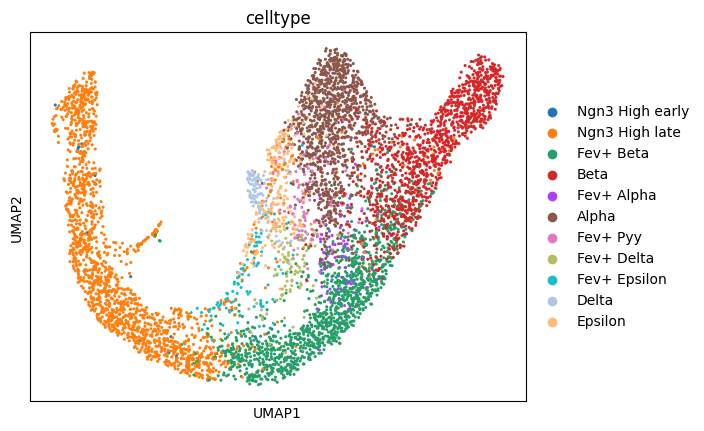

In [17]:
sc.pl.umap(bdata, color="celltype")

In [17]:
res = [None] * 15

for i in range(15):
    res[i]= otfm.transport(source, seed=i)[0][0,...]


In [18]:
samples = jnp.array(res)
vars = jnp.var(samples, axis=0)
vars_summed = jnp.sum(vars, axis=1)

In [19]:
fill = np.empty(len(target))[:, None]
fill[:] = np.nan
bdata.obs["var"] = np.asarray(np.concatenate((vars_summed[:, None], fill)))

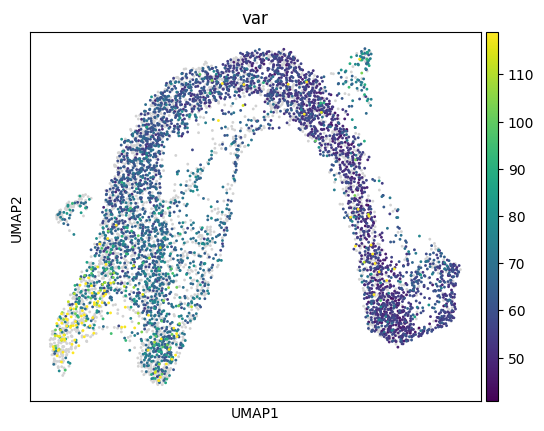

In [20]:
sc.pl.umap(bdata, color="var", vmax="p98")

In [21]:
bdata.obs[["celltype", "var"]].groupby("celltype").mean()

,var
celltype,
Ngn3 low EP,55.255823
Ngn3 High early,60.342357
Ngn3 High late,56.159899
Fev+ Beta,59.983154
Beta,82.448224
Fev+ Alpha,60.367577
Alpha,70.428641
Fev+ Pyy,68.781406
Fev+ Delta,71.884063


In [25]:
bdata.obs[["celltype", "var"]].groupby("celltype").mean()

,var
celltype,
Ngn3 High early,27.105014
Ngn3 High late,17.975490
Fev+ Beta,11.202564
Beta,6.840672
Fev+ Alpha,11.690473
Alpha,9.482847
Fev+ Pyy,10.690583
Fev+ Delta,14.898126
Fev+ Epsilon,15.010829


In [55]:
bdata.obs[["celltype", "var"]].groupby("celltype").mean()

,var
celltype,
Ngn3 High early,8.139357
Ngn3 High late,4.129417
Fev+ Beta,4.103469
Beta,2.103152
Fev+ Alpha,3.249933
Alpha,2.750842
Fev+ Pyy,3.166773
Fev+ Delta,5.023872
Fev+ Epsilon,4.899799


In [ ]:
from typing import Tuple, Callable, Union, List, Optional
import scipy.sparse as sp

def get_nearest_neighbors(
    input_batch: jnp.ndarray, target: jnp.ndarray, k: int = 30
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Get the k nearest neighbors of the input batch in the target."""
    if target.shape[0] < k:
        raise ValueError(f"k is {k}, but must be smaller or equal than {target.shape[0]}.")
    pairwise_euclidean_distances = jnp.sqrt(jnp.sum((input_batch - target) ** 2, axis=-1))
    negative_distances, indices = jax.lax.top_k(-1 * pairwise_euclidean_distances, k=k)
    return -1 * negative_distances, indices

def project_transport_matrix(  # type:ignore[override]
        transport_map: Callable[[jnp.ndarray], jnp.ndarray],
        src_cells: jnp.ndarray,
        tgt_cells: jnp.ndarray,
        batch_size: int = 1024,
        k: int = 1,
    ) -> sp.csr_matrix:
        """Project Neural OT map onto cells."""

        get_knn_fn = jax.vmap(get_nearest_neighbors, in_axes=(0, None, None), k=k)
        row_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        column_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        distances_list: Union[jnp.ndarray, List[jnp.ndarray]] = []
        for index in range(0, len(src_cells), batch_size):
            _, indices = get_knn_fn(transport_map(src_cells[index : index + batch_size]), tgt_cells, k)
            column_indices.append(indices.flatten())
            row_indices.append(
                jnp.repeat(jnp.arange(index, index + min(batch_size, len(src_cells) - index)), min(k, len(tgt_cells)))
            )
        row_indices = jnp.concatenate(row_indices)
        column_indices = jnp.concatenate(column_indices)
        tm = sp.csr_matrix((1.0, (row_indices, column_indices)), shape=[len(src_cells), len(tgt_cells)])
        return tm